In [1]:
import tempfile
import pickle as pkl
from pathlib import Path
import os
import yaml

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer

import mlflow

from bayes_opt import BayesianOptimization
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import GPT2Tokenizer

import shap

from auxiliar import crear_ensemble_donadas

In [2]:
# Paramètres
with open("config.yml", "r", encoding="utf-8") as file:
    config = yaml.safe_load(file)

INPUT_FICHIER_WIKI_TEXTE = config["camins"]["texte"]["fichier_wiki_texte"]

INPUT_FICHER_WIKI_ETIQUETAS_ALEATORI = config["camins"]["etiquetas"]["fichier_wiki_etiquetas_aleatori"]
INPUT_FICHER_WIKI_ETIQUETAS_AUTOMATIC = config["camins"]["etiquetas"]["fichier_wiki_etiquetas_automatic"]
INPUT_FICHER_WIKI_ETIQUETAS_ENTROPIA = config["camins"]["etiquetas"]["fichier_wiki_etiquetas_entropia"]

INPUT_DOSSIER_TOKENIZAIRE = config["camins"]["tokenizaire"]["dossier_tokenizaire"]

OUTPUT_PREDICCIONS = config["camins"]["classificador"]["xgboost"]["prediccions"]
OUTPUT_SELECCION_PAGINAS = config["camins"]["classificador"]["xgboost"]["seleccion_paginas"]
OUTPUT_DOSSIER_MODEL = config["camins"]["classificador"]["xgboost"]["dossier_model"]

OPTIMIZACION_BAYESIANA = False

In [3]:
texte_df = pd.read_csv(INPUT_FICHIER_WIKI_TEXTE)

texte_etiquetas_df = crear_ensemble_donadas(
    texte_df=texte_df,
    lista_dialectes_df=[
        pd.read_csv(INPUT_FICHER_WIKI_ETIQUETAS_ALEATORI),
        pd.read_csv(INPUT_FICHER_WIKI_ETIQUETAS_AUTOMATIC),
        pd.read_csv(INPUT_FICHER_WIKI_ETIQUETAS_ENTROPIA),
    ],
)
texte_etiquetas_df

,Article,Dialecte,Texte
0,Vieux-Champagne,lengadocian,vieux-champagne es una situada dins lo de sèin...
1,Ereditat,lengadocian,lereditat (del latin hereditas çò que s'erita ...
2,White_Town,lengadocian,white town es un projècte britanic de musica e...
3,Puigverd_d'Agramunt,lengadocian,puigverd d'agramunt es un de la
4,La_Grande_Montagne,lengadocian,la grande montagne es una de sant bartomieu di...
...,...,...,...
8308,Coduras,gascon,coduras
8309,Cobluc,gascon,cobluc
8310,Michal_Kováč,lengadocian,michal ková banquièr e òme politic (ubia 5 d'a...
8311,La_Bruguièra_Dorçan,lengadocian,la bruguièra dorçan


In [4]:
texte_etiquetas_entrenament, texte_etiquetas_test = train_test_split(texte_etiquetas_df, test_size=0.2)

In [5]:
# Crear sac a mots
tokenizaire = GPT2Tokenizer.from_pretrained(
    INPUT_DOSSIER_TOKENIZAIRE,
    do_lower_case=True,
)
tokens_entrenament = texte_etiquetas_entrenament["Texte"].apply(tokenizaire.tokenize).apply(lambda x: " ".join(x))
tokens_test = texte_etiquetas_test["Texte"].apply(tokenizaire.tokenize).apply(lambda x: " ".join(x))
tokens_tot = texte_df["Texte"].apply(tokenizaire.tokenize).apply(lambda x: " ".join(x))

vectorizador = CountVectorizer()
bow_entrenament = vectorizador.fit_transform(tokens_entrenament)
bow_test = vectorizador.transform(tokens_test)
bow_tot = vectorizador.transform(tokens_tot)

# Codificar los dialèctes
codificador_ordinal = OrdinalEncoder()
etiquetas_entrenament = codificador_ordinal.fit_transform(texte_etiquetas_entrenament[["Dialecte"]]).astype(int)
etiquetas_test = codificador_ordinal.transform(texte_etiquetas_test[["Dialecte"]]).astype(int)

In [6]:
melhor_params = {}
if OPTIMIZACION_BAYESIANA:

    def evaluar(max_depth, learning_rate, n_estimators, gamma, min_child_weight, subsample, colsample_bytree):
        kf = KFold(n_splits=3)
        f1_scores = []

        for train_index, valid_index in kf.split(bow_entrenament):

            xgb = XGBClassifier(
                max_depth=int(max_depth),
                learning_rate=learning_rate,
                n_estimators=int(n_estimators),
                gamma=gamma,
                min_child_weight=min_child_weight,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
            )
            xgb.fit(
                bow_entrenament[train_index],
                etiquetas_entrenament[train_index],
                sample_weight=compute_sample_weight("balanced", etiquetas_entrenament[train_index]),
                verbose=False,
            )
            etiquetas_predichas = xgb.predict(bow_entrenament[valid_index])
            score = f1_score(etiquetas_entrenament[valid_index], etiquetas_predichas, average="macro")
            f1_scores.append(score)

        return np.mean(f1_scores)

    limits = {
        "max_depth": (3, 12),
        "learning_rate": (0.01, 0.5),
        "n_estimators": (50, 200),
        "gamma": (0, 0.5),
        "min_child_weight": (1, 10),
        "subsample": (0.5, 1),
        "colsample_bytree": (0.5, 1),
    }

    optimizaire = BayesianOptimization(f=evaluar, pbounds=limits, random_state=63, verbose=2)

    optimizaire.maximize(init_points=10, n_iter=20)

    melhor_params = optimizaire.max["params"]
    melhor_params["max_depth"] = int(melhor_params["max_depth"])
    melhor_params["n_estimators"] = int(melhor_params["n_estimators"])

Exactitud: 0.9332531569452797
Precision: 0.7938443440079418
Rappel: 0.819245123222396
F1: 0.8046387638133454


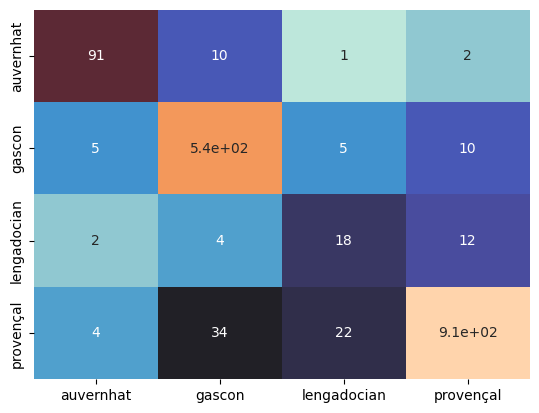

In [7]:
# Initialize MLflow
mlflow.set_experiment("XGBoost")
os.makedirs("mlruns", exist_ok=True)

# Start an MLflow run
with mlflow.start_run():

    # Entrenar e gardar lo darrièr model
    xgb_final = XGBClassifier(
        **melhor_params,
    )

    xgb_final.fit(
        bow_entrenament,
        etiquetas_entrenament,
        sample_weight=compute_sample_weight("balanced", etiquetas_entrenament),
    )
    for nom_param, valor_param in melhor_params.items():
        mlflow.log_param(nom_param, valor_param)

    # Predire e evaluar lo model
    y_pred_test = xgb_final.predict(bow_test).reshape(-1, 1)

    # Transformar las etiquetas numericas en etiquetas textualas
    dialecte_obs_test = codificador_ordinal.inverse_transform(etiquetas_test)
    dialecte_pred_test = codificador_ordinal.inverse_transform(y_pred_test)

    # Exactitud, Precision, Rappel, F1
    exactitud = accuracy_score(dialecte_obs_test, dialecte_pred_test)
    precision, rappel, f1, _ = precision_recall_fscore_support(
        dialecte_obs_test,
        dialecte_pred_test,
        average="macro",
    )
    print(f"Exactitud: {exactitud}\nPrecision: {precision}\nRappel: {rappel}\nF1: {f1}")
    mlflow.log_metric("exactitud", exactitud)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("rappel", rappel)
    mlflow.log_metric("f1", f1)

    # Matritz de confusion
    matritz_confusion = confusion_matrix(dialecte_obs_test, dialecte_pred_test)
    matritz_confusion_df = pd.DataFrame(
        matritz_confusion,
        index=codificador_ordinal.categories_[0],
        columns=codificador_ordinal.categories_[0],
    )
    fig = sns.heatmap(np.log(matritz_confusion_df + 1), annot=matritz_confusion_df, cbar=None, cmap="icefire")
    with tempfile.NamedTemporaryFile(suffix=".png") as temp_file:
        plt.savefig(temp_file.name)
        mlflow.log_artifact(temp_file.name, artifact_path="images")

In [10]:
with open(Path(OUTPUT_DOSSIER_MODEL) / Path("vectorizador.pkl"), "wb") as f:
    pkl.dump(vectorizador, f)

with open(Path(OUTPUT_DOSSIER_MODEL) / Path("codificador_ordinal.pkl"), "wb") as f:
    pkl.dump(codificador_ordinal, f)

with open(Path(OUTPUT_DOSSIER_MODEL) / Path("classificador.pkl"), "wb") as f:
    pkl.dump(xgb_final, f)

In [11]:
# Generar prediccions per totes los articles
y_pred_tot = xgb_final.predict(bow_tot).reshape(-1, 1)
y_prob_tot = xgb_final.predict_proba(bow_tot)
entropia_tot = np.sum(-y_prob_tot * np.log(y_prob_tot), axis=1)
resultats_df = pd.DataFrame(
    {
        "Article": texte_df["Article"],
        "Prediccion": codificador_ordinal.inverse_transform(y_pred_tot).reshape(-1),
        "Entropia": entropia_tot.reshape(-1),
    }
)
resultats_df = pd.concat(
    [resultats_df, pd.DataFrame(y_prob_tot, columns=codificador_ordinal.categories_[0])],
    axis=1,
)
resultats_df = resultats_df.merge(texte_etiquetas_df[["Article", "Dialecte"]], on="Article", how="left")
resultats_df.to_csv(OUTPUT_PREDICCIONS, index=False)
resultats_df.sort_values("Entropia", ascending=False)["Article"].to_csv(
    OUTPUT_SELECCION_PAGINAS, index=False, header=False
)
resultats_df.sort_values("Entropia", ascending=False)

,Article,Prediccion,Entropia,auvernhat,gascon,lengadocian,provençal,Dialecte
64105,Martín_Vizcarra,gascon,1.382221,2.286954e-01,0.288065,2.368523e-01,2.463877e-01,NaN
75603,Laneuvelle,auvernhat,1.380491,2.791699e-01,0.260584,2.070399e-01,2.532059e-01,NaN
33256,Rouville,provençal,1.379663,2.498934e-01,0.233199,2.199041e-01,2.970033e-01,NaN
51035,Barville,provençal,1.379663,2.498934e-01,0.233199,2.199041e-01,2.970033e-01,NaN
19831,Francheville,provençal,1.379663,2.498934e-01,0.233199,2.199041e-01,2.970033e-01,NaN
...,...,...,...,...,...,...,...,...
40816,John_Wayne,gascon,0.000026,7.387298e-07,0.999998,4.669479e-07,4.982514e-07,NaN
74006,Guarneri_Vieuxtemps,gascon,0.000026,4.922466e-07,0.999998,2.213513e-07,9.937596e-07,gascon
6608,Aton,gascon,0.000026,7.566793e-08,0.999998,2.067180e-07,1.469097e-06,gascon
29607,Mandolina,gascon,0.000023,5.549552e-07,0.999999,2.622048e-07,6.416692e-07,gascon


<Axes: xlabel='Prediccion', ylabel='Entropia'>

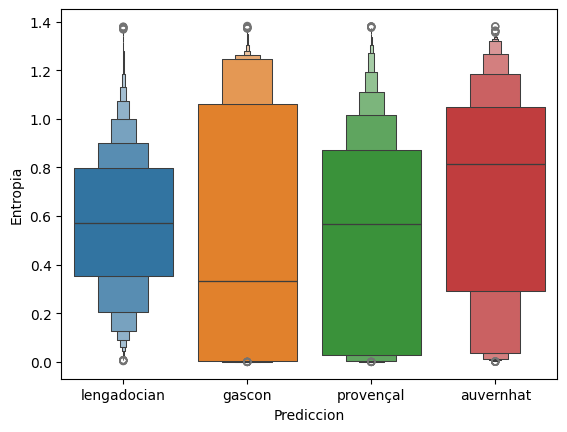

In [12]:
sns.boxenplot(data=resultats_df, x="Prediccion", y="Entropia", hue="Prediccion")

In [13]:
resultats_df.query('Dialecte.isnull() & Prediccion == "lengadocian"').sort_values("Entropia", ascending=False).head(20)

,Article,Prediccion,Entropia,auvernhat,gascon,lengadocian,provençal,Dialecte
43509,Brotomys,lengadocian,1.379440,0.202955,0.250353,0.274501,0.272191,NaN
72530,Sant_Maurici,lengadocian,1.377648,0.270371,0.211985,0.292829,0.224816,NaN
33384,Entraigas_(Vivarés),lengadocian,1.376955,0.235982,0.261557,0.297765,0.204696,NaN
83318,Abdoulaye_Wade,lengadocian,1.374447,0.206851,0.224059,0.307940,0.261151,NaN
65787,Chapsierjas,lengadocian,1.373830,0.190225,0.241134,0.284455,0.284186,NaN
6840,Candan_Erçetin,lengadocian,1.369395,0.219277,0.192022,0.301558,0.287143,NaN
25335,Adieu,lengadocian,1.367641,0.175950,0.264282,0.306678,0.253090,NaN
47696,Belmont-Luthézieu,lengadocian,1.365532,0.179934,0.268558,0.318435,0.233073,NaN
13377,Drincham,lengadocian,1.364527,0.175927,0.259909,0.320937,0.243227,NaN
26353,Sigoier,lengadocian,1.363006,0.172042,0.236757,0.316049,0.275151,NaN


In [14]:
resultats_df.query('Dialecte.isnull() & Prediccion == "auvernhat"').sort_values("Entropia", ascending=False).head(20)

,Article,Prediccion,Entropia,auvernhat,gascon,lengadocian,provençal,Dialecte
75603,Laneuvelle,auvernhat,1.380491,0.279170,0.260584,0.207040,0.253206,NaN
14957,Campionat_del_Mond_d'atletisme_de_1993,auvernhat,1.379348,0.283171,0.240052,0.207212,0.269565,NaN
80779,Patrimòni_Culturau_Immateriau,auvernhat,1.363018,0.341515,0.201789,0.245897,0.210799,NaN
13501,Puget,auvernhat,1.360962,0.323738,0.248950,0.168003,0.259309,NaN
85376,Arachnida,auvernhat,1.360545,0.304796,0.159399,0.265338,0.270467,NaN
76475,Sant-Kristol-ar-C'hoad,auvernhat,1.359738,0.320713,0.164025,0.248765,0.266497,NaN
58423,Francesc_Layret,auvernhat,1.358986,0.353651,0.202704,0.228597,0.215048,NaN
24949,Aliscamps,auvernhat,1.354154,0.348439,0.175722,0.216241,0.259599,NaN
8521,Fòrt,auvernhat,1.350785,0.305773,0.272115,0.279118,0.142994,NaN
18855,EPITECH_European_Institute_of_Information_Tech...,auvernhat,1.345849,0.298757,0.292199,0.135480,0.273563,NaN


In [15]:
texte_etiquetas_df.groupby("Dialecte")["Article"].count()

Dialecte
auvernhat       514
gascon         2855
lengadocian     164
provençal      4780
Name: Article, dtype: int64

In [16]:
resultats_df.groupby("Prediccion")["Article"].count()

Prediccion
auvernhat       1866
gascon         12498
lengadocian    50581
provençal      20600
Name: Article, dtype: int64

In [17]:
# explicador = shap.TreeExplainer(xgb_final)
# shap_df = pd.DataFrame(explicador(bow_test), index=texte_etiquetas_test["Article"], columns=vocab_list)

In [19]:
vocab = {v: k for k, v in vectorizador.vocabulary_.items()}
vocab_list = [vocab[i] for i in range(len(vocab))]

fi_df = pd.DataFrame({"FI": xgb_final.feature_importances_})
fi_df["TokenIndex"] = list(range(0, fi_df.shape[0]))
fi_df["Token"] = fi_df["TokenIndex"].map(lambda x: vocab[x])
fi_df.sort_values("FI", ascending=False).head(60)

,FI,TokenIndex,Token
17233,0.077835,17233,ġua
9655,0.060010,9655,ġdei
2212,0.037202,2212,es
9930,0.024854,9930,ġdeu
15554,0.021552,15554,ġreferences
9560,0.020943,9560,ġdau
9678,0.018365,9678,ġdels
12651,0.017761,12651,ġlei
12850,0.015971,12850,ġloire
5203,0.014844,5203,tamar
